### **CALL LOG PREDICTION**

In [ ]:
!pip install scikit-plot

### Importing Essential Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix,f1_score, make_scorer, plot_roc_curve
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, Normalizer
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from yellowbrick.classifier import ClassificationReport
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

### Importing the dataset

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/term-deposit-marketing-2020.csv')

### Displaying the dataset

In [ ]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,no


### Checking and Cleaning Unknown Datas

Before using dataset, I have checked the missing datas.

In [ ]:
unknown_job = 0
unknown_marital = 0 
unknown_education = 0
unknown_contact = 0
for i in range(0,len(dataset)):
  if dataset.iloc[i,1] == "unknown":
    unknown_job += 1
  if dataset.iloc[i,2] == "unknown":
    unknown_marital += 1
  if dataset.iloc[i,3] == "unknown":
    unknown_education += 1
  if dataset.iloc[i,8] == "unknown":
    unknown_contact += 1
print("unknown job ratio is :" + str(unknown_job/len(dataset)))
print("unknown marital ratio is :" + str(unknown_marital/len(dataset)))
print("unknown education ratio is :" + str(unknown_education/len(dataset)))
print("unknown contact ratio is :" + str(unknown_contact/len(dataset)))

unknown job ratio is :0.005875
unknown marital ratio is :0.0
unknown education ratio is :0.038275
unknown contact ratio is :0.319125


I need to replace "unknown" with "nan" in order to use it in remaining parts

In [ ]:
dataset = dataset.replace('unknown', np.nan)

In [ ]:
print(dataset.isnull().sum(axis = 0))

age              0
job            235
marital          0
education     1531
default          0
balance          0
housing          0
loan             0
contact      12765
day              0
month            0
duration         0
campaign         0
y                0
dtype: int64


I have dropped the "contact" column, because it has 31.9% unknown datas

In [ ]:
dataset = dataset.drop(columns = ['contact'])

### Splitting the data into training and test sets

Dividing the columns as input attributes and output

In [ ]:
X = pd.DataFrame(dataset.iloc[:,:-1].values)
y = pd.DataFrame(dataset.iloc[:,-1].values)
column_names = dataset.columns

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 10, test_size = 0.05)
y_train = y_train.rename(columns={0:'target'})
y_test = y_test.rename(columns={0:'target'})
dataset_train = pd.concat([X_train, y_train], axis = 1)
dataset_test = pd.concat([X_test, y_test], axis = 1)
dataset_train.columns = column_names
dataset_test.columns = column_names

## Dealing with unknown categorical data

In order to deal with data leakage, I have dealed with unknown columns seperately for test set and training set

FOR TRAINING SET : I need to deal with other missing values, for categorical data I have used most frequent method



In [ ]:
job_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

## Nan Values of Job type is replaced with most frequent one
job_column = dataset_train.iloc[:,1].values
job_column = job_column.reshape(-1,1)
job_imputer.fit(job_column)
job_column = job_imputer.transform(job_column)
dataset_train.iloc[:,1] = job_column

education_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
## Nan Values of Education is replaced with most frequent one
education_column = dataset_train.iloc[:,3].values
education_column = education_column.reshape(-1,1)
education_imputer.fit(education_column)
education_column = education_imputer.transform(education_column)
dataset_train.iloc[:,3] = education_column

There is no nan value anymore in the training set

In [ ]:
print(dataset_train.isnull().sum(axis = 0))

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


FOR TEST SET : I need to deal with other missing values, for categorical data I have used most frequent method

In [ ]:
job_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

## Nan Values of Job type is replaced with most frequent one
job_column = dataset_test.iloc[:,1].values
job_column = job_column.reshape(-1,1)
job_imputer.fit(job_column)
job_column = job_imputer.transform(job_column)
dataset_test.iloc[:,1] = job_column

education_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
## Nan Values of Education is replaced with most frequent one
education_column = dataset_test.iloc[:,3].values
education_column = education_column.reshape(-1,1)
education_imputer.fit(education_column)
education_column = education_imputer.transform(education_column)
dataset_test.iloc[:,3] = education_column

There is no nan value anymore in the test set.

In [ ]:
print(dataset_test.isnull().sum(axis = 0))

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
day          0
month        0
duration     0
campaign     0
y            0
dtype: int64


## Encoding the data

I have used onehotencoder for ['job' , 'marital' , 'education' , 'month'] attributes because these attributes does not have order; therefore, labelencoder will not be suitable for this case
However, for ['housing' , 'loan', 'default'] attributes labelencoder is more suitable because these are binary values

In [ ]:
## FOR TRAINING SET
le = LabelEncoder()
dataset_train.iloc[:,-1] = le.fit_transform(dataset_train.iloc[:,-1]) # for target
dataset_train.iloc[:,-6] = le.fit_transform(dataset_train.iloc[:,-6]) # for loan
dataset_train.iloc[:,-7] = le.fit_transform(dataset_train.iloc[:,-7]) # for housing
dataset_train.iloc[:,-9] = le.fit_transform(dataset_train.iloc[:,-9]) # for default

ct_x = ColumnTransformer( transformers = [('encoder', OneHotEncoder(), ['job', 'marital','education','month'])],
                       remainder = 'passthrough')
le = LabelEncoder()
dataset_train.iloc[:,-1] = le.fit_transform(dataset_train.iloc[:,-1]) # for target
dataset_train = (ct_x.fit_transform(dataset_train)) 
dataset_train = pd.DataFrame(dataset_train)

## FOR TEST SET
le = LabelEncoder()
dataset_test.iloc[:,-6] = le.fit_transform(dataset_test.iloc[:,-6]) # for loan
dataset_test.iloc[:,-7] = le.fit_transform(dataset_test.iloc[:,-7]) # for housing
dataset_test.iloc[:,-9] = le.fit_transform(dataset_test.iloc[:,-9]) # for default
ct_x = ColumnTransformer( transformers = [('encoder', OneHotEncoder(), ['job', 'marital','education','month'])],
                       remainder = 'passthrough')
le = LabelEncoder()
dataset_test.iloc[:,-1] = le.fit_transform(dataset_test.iloc[:,-1]) # for target
dataset_test = (ct_x.fit_transform(dataset_test)) 
dataset_test = pd.DataFrame(dataset_test)

## Checking if the dataset is imbalanced

This blocks checks if the training data is imbalanced, and the result shows that we are dealing with imbalanced data. Therefore, in order to show how good our model we need more than accuracy rate.

No Class : 35266
Yes Class : 2734


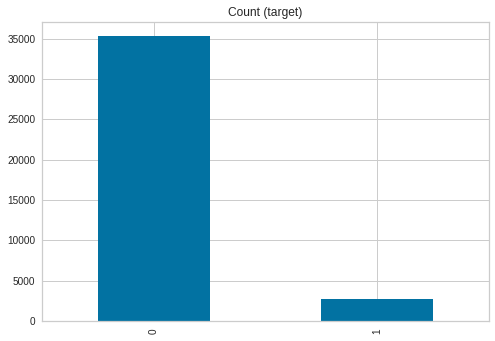

In [ ]:
target_count = dataset_train.iloc[:,36].value_counts()
print('No Class :', target_count[0])
print('Yes Class :', target_count[1])

target_count.plot(kind='bar', title='Count (target)');

## Resampling

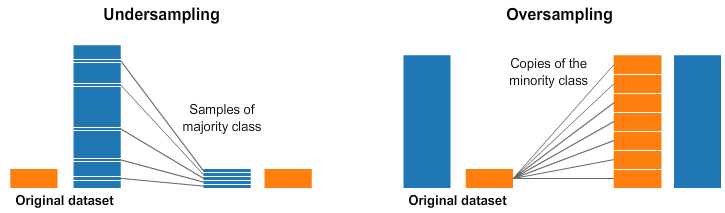

One approach to addressing the problem of class imbalance is to randomly resample the training dataset. The two main approaches to randomly resampling an imbalanced dataset are to delete examples from the majority class, called undersampling, and to duplicate examples from the minority class, called oversampling. 
( https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/ ) 

Random under-sampling:
1    2734
0    2734
Name: target, dtype: int64


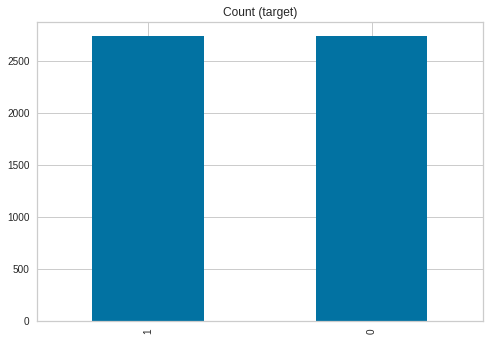

In [ ]:
dataset_test = dataset_test.rename(columns= {36:'target'})
dataset_train = dataset_train.rename(columns= {36:'target'})
# Class count
count_class_0, count_class_1 = dataset_train.target.value_counts()

# Divide by class
df_class_0 = dataset_train[dataset_train['target'] == 0]
df_class_1 = dataset_train[dataset_train['target'] == 1]

df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.target.value_counts())

df_train_under.target.value_counts().plot(kind='bar', title='Count (target)');
plt.show()


In [ ]:
X_train = df_train_under.iloc[:,:-1].values
y_train = df_train_under.iloc[:,-1].values
y_train = y_train.astype('int')

X_test = dataset_test.iloc[:,:-1].values
y_test = dataset_test.iloc[:,-1].values
y_test = y_test.astype('int')

## Feature Scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

X_train_stand = X_train.copy()
X_test_stand = X_test.copy()

for i in range(0,36):
    
    scale = StandardScaler().fit(X_train_stand[:,[i]])
    
    X_train[:,[i]] = scale.transform(X_train_stand[:,[i]])
    X_test[:,[i]] = scale.transform(X_test_stand[:,[i]])

In [ ]:
#transformer = Normalizer().fit(X_train)
#transformer
#transformer.transform(X_train)
#transformer.transform(X_test)

## Model Selection

In the dataset, we are searching for yes values therefore recall is more important then the precision.

---
*  **Precision** : What proportion of positive identifications was actually correct?




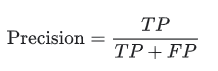
*  **Recall** : What proportion of actual positives was identified correctly?


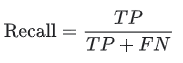

###**SVC** Model

In [ ]:

#
param_grid = {'C': [0.1, 1, 10, 100, 1000],  'gamma': ['auto'], 'kernel': ['rbf']}    
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3) 
 
grid.fit(X_train, y_train) 
print (grid.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.1, gamma=auto, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.832, total=   1.4s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.850, total=   1.3s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.816, total=   1.3s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.824, total=   1.3s
[CV] C=0.1, gamma=auto, kernel=rbf ...................................
[CV] ....... C=0.1, gamma=auto, kernel=rbf, score=0.840, total=   1.3s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.836, total=   1.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.868, total=   1.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.844, total=   1.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] ......... C=1, gamma=auto, kernel=rbf, score=0.852, total=   1.0s
[CV] C=1, gamma=auto, kernel=rbf .....................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:   33.0s finished


{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}


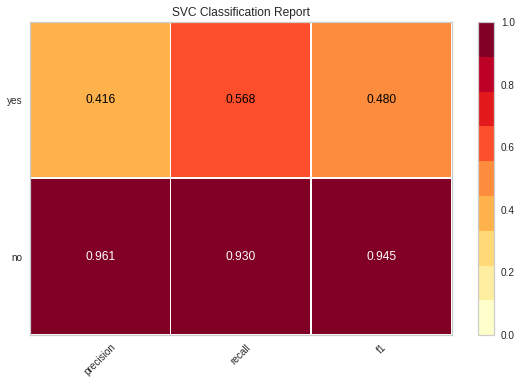

accuracy of SVC:	0.9005


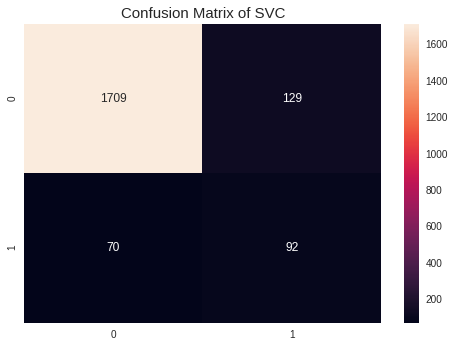

In [ ]:
classifier_SVC = SVC(C = 10, gamma = 0.00001, kernel = 'rbf', probability = True)
visualizer_SVC = ClassificationReport(classifier_SVC, classes=['no','yes'])
visualizer_SVC.fit(X_train, y_train) #
y_pred = visualizer_SVC.predict(X_test)
visualizer_SVC.score(X_test, y_test) 
g = visualizer_SVC.poof() 
print("accuracy of SVC:\t" + str(accuracy_score(y_test,y_pred)))
confusion_matrix_SVC = confusion_matrix(y_test,y_pred)

plt.title("Confusion Matrix of SVC", fontsize =15)
sns.heatmap(confusion_matrix_SVC, annot=True, fmt='g')

###MLP

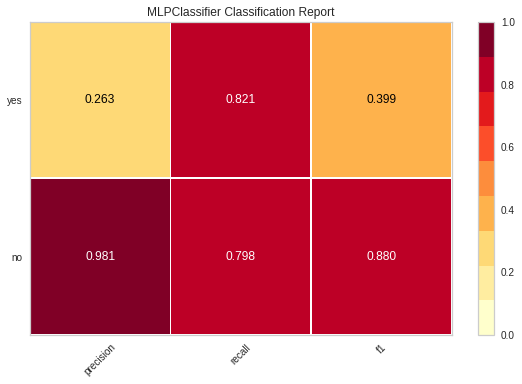

accuracy of MLP:	0.7995


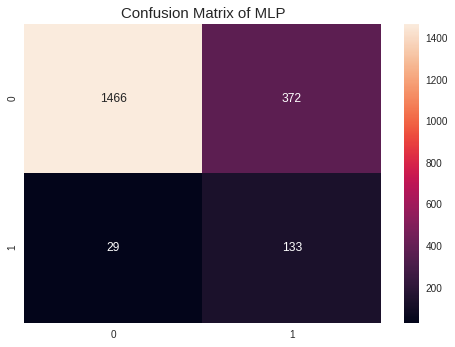

In [ ]:
clf = MLPClassifier(alpha=1e-4,
                    hidden_layer_sizes=(74,50,10), random_state=1)
clf.fit(X_train, y_train)
visualizer_MLP = ClassificationReport(clf, classes=['no','yes'])
visualizer_MLP.fit(X_train, y_train) #
y_pred4 = visualizer_MLP.predict(X_test)
visualizer_MLP.score(X_test, y_test) 
g = visualizer_MLP.poof() 
confusion_matrix_MLP = confusion_matrix(y_test,y_pred4)
print("accuracy of MLP:\t" + str(accuracy_score(y_test,y_pred4)))
plt.title("Confusion Matrix of MLP", fontsize =15)
sns.heatmap(confusion_matrix_MLP, annot=True, fmt='g')

###Random Forest Classifier

In [ ]:
rfc = RandomForestClassifier(n_jobs=-1 , oob_score = True) 

param_grid = { 
    'n_estimators': [50,100,200, 700],
    'max_features': ['auto', 'sqrt', 'log2'],
    'criterion' : ['gini'],
    'class_weight' : ['balanced', None]
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring = 'f1')
CV_rfc.fit(X_train, y_train)
print (CV_rfc.best_params_)

{'class_weight': 'balanced', 'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 700}


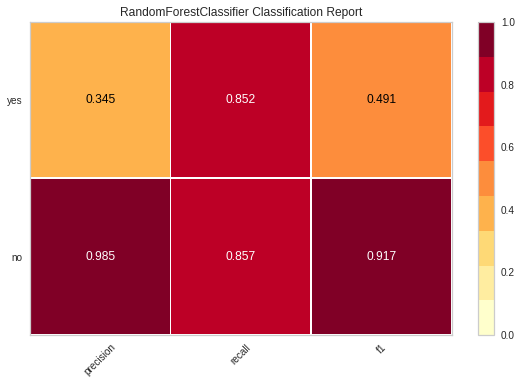

accuracy of RFC:	0.857


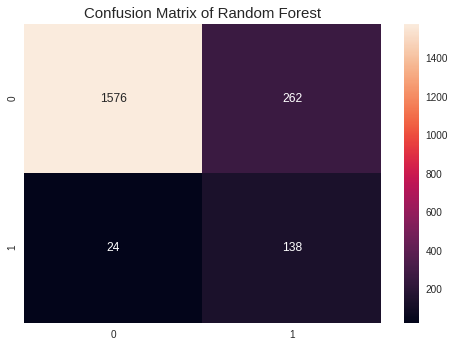

In [ ]:
rfc = RandomForestClassifier(class_weight= None, criterion= 'gini', max_features= 'sqrt', n_estimators= 700)
visualizer_RFC = ClassificationReport(rfc, classes=['no','yes'])
visualizer_RFC.fit(X_train, y_train) #
y_pred2 = visualizer_RFC.predict(X_test)
visualizer_RFC.score(X_test, y_test) 
g = visualizer_RFC.poof() 

print("accuracy of RFC:\t" + str(accuracy_score(y_test,y_pred2)))
confusion_matrix_RFC = confusion_matrix(y_test,y_pred2)
plt.title("Confusion Matrix of Random Forest", fontsize =15)
sns.heatmap(confusion_matrix_RFC, annot=True, fmt='g')

###Naive Bayes Model

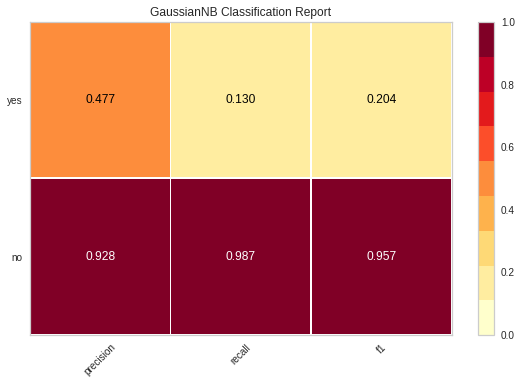

accuracy of GNB:	0.918


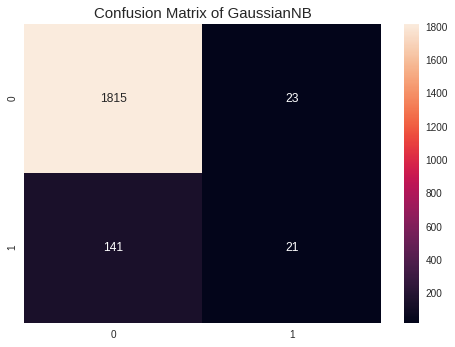

In [ ]:
gnb = GaussianNB()
visualizer_GNB = ClassificationReport(gnb, classes=['no','yes'])
visualizer_GNB.fit(X_train, y_train) #
y_pred3 = gnb.predict(X_test)
visualizer_GNB.score(X_test, y_test) 
g = visualizer_GNB.poof() 

print("accuracy of GNB:\t" + str(accuracy_score(y_test,y_pred3)))
confusion_matrix_GNB = confusion_matrix(y_test,y_pred3)
plt.title("Confusion Matrix of GaussianNB", fontsize =15)
sns.heatmap(confusion_matrix_GNB, annot=True, fmt='g')

ROC CURVE

As can be seen in Figure, the best model is RandomForestClassifier. Area Under the Curve percentage is the highest one.

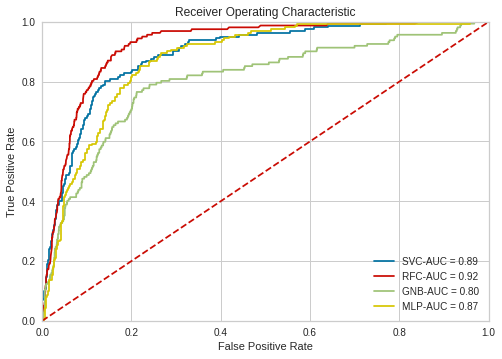

In [ ]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs_RFC = visualizer_RFC.predict_proba(X_test)
preds_RFC = probs_RFC[:,1]
fpr_RFC, tpr_RFC, threshold_RFC = metrics.roc_curve(y_test, preds_RFC)
roc_auc_RFC = metrics.auc(fpr_RFC, tpr_RFC)

probs_GNB = visualizer_GNB.predict_proba(X_test)
preds_GNB = probs_GNB[:,1]
fpr_GNB, tpr_GNB, threshold_GNB = metrics.roc_curve(y_test, preds_GNB)
roc_auc_GNB = metrics.auc(fpr_GNB, tpr_GNB)

probs_SVC = visualizer_SVC.predict_proba(X_test)
preds_SVC = probs_SVC[:,1]
fpr_SVC, tpr_SVC, threshold_SVC = metrics.roc_curve(y_test, preds_SVC)
roc_auc_SVC = metrics.auc(fpr_SVC, tpr_SVC)

probs_MLP = visualizer_MLP.predict_proba(X_test)
preds_MLP = probs_MLP[:,1]
fpr_MLP, tpr_MLP, threshold_MLP = metrics.roc_curve(y_test, preds_MLP)
roc_auc_MLP = metrics.auc(fpr_MLP, tpr_MLP)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_SVC, tpr_SVC, 'b', label = 'SVC-AUC = %0.2f' % roc_auc_SVC)
plt.plot(fpr_RFC, tpr_RFC, 'r', label = 'RFC-AUC = %0.2f' % roc_auc_RFC)
plt.plot(fpr_GNB, tpr_GNB, 'g', label = 'GNB-AUC = %0.2f' % roc_auc_GNB)
plt.plot(fpr_MLP, tpr_MLP, 'y', label = 'MLP-AUC = %0.2f' % roc_auc_MLP)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## K-Fold Cross Validation

K-Fold cross validation is applied to RandomForest because it gave the best outputs.

In [ ]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train,y_test), axis= 0)
scores = []
scoresf1 = []
best_rfc = RandomForestClassifier(class_weight= None, criterion= 'gini', max_features= 'sqrt', n_estimators= 700)
cv = KFold(n_splits=5)
for train_index, test_index in cv.split(X):
    X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
    best_rfc.fit(X_train, y_train)
    y_pred_rfc = best_rfc.predict(X_test)
    scores.append(best_rfc.score(X_test, y_test)),
    scoresf1.append(f1_score(y_test, y_pred_rfc, average='macro'))

print("F1 scores:")
print(scoresf1)
print("Accuracy scores:")
print(scores)

average_f1 = 0
average_Accuracy = 0 
for i in range(0,5):
  average_f1 = average_f1 + scoresf1[i]
  average_Accuracy = average_Accuracy + scores[i]
average_Accuracy = average_Accuracy / 5
average_f1 = average_f1 / 5

print("Average Accuracy")
print(average_Accuracy)
print("Average F1 Score :")
print(average_f1)

F1 scores:
[0.45947901591895807, 0.8109293590209621, 0.42093023255813955, 0.8254519474333717, 0.7084131613018778]
Accuracy scores:
[0.8500669344042838, 0.8741633199464525, 0.7269076305220884, 0.8372404554588078, 0.8626925653047556]
Average Accuracy
0.8302141811272777
Average F1 Score :
0.6450407432466619


## Feature Importance

As can be seen from the figure, duration has a very high impact on the output 

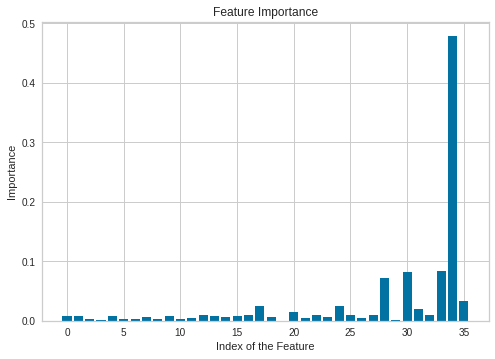

In [ ]:
importance = best_rfc.feature_importances_
# summarize feature importance
# plot feature importance
plt.title("Feature Importance")
plt.xlabel("Index of the Feature")
plt.ylabel("Importance")
plt.bar([x for x in range(len(importance))], importance)
plt.show()